# Global indicator project - Phoenix, Arizona

## Pandana network accessibility - amenities
This notebook uses [pandana](https://udst.github.io/pandana/network.html) to download street network and points-of-interest data from OpenStreetMap and then calculate network accessibility to the points of interest. 
Learn from example [here](https://github.com/gboeing/urban-data-science/blob/59afcff905649c5f8d1f8256ec37f28496e0c740/20-Accessibility-Walkability/pandana-accessibility-demo-simple.ipynb)

Note: pandana currently only runs on Python 2.

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import numpy as np
import requests
import pandas as pd
import geopandas as gpd
import os
import time 

import config

#import pandana library
import pandana
from pandana.loaders import osm

ox.config(use_cache=True, log_console=True)
ox.__version__

In [3]:
suffix = config.time

place = config.places.values()[0]
place

'Phoenix, Arizona, USA'

## Set up configuration 

In [5]:
# configure search at a max distance of 1 km for up to the 10 nearest points-of-interest
shop = ['supermarket', 'convenience']
distance = 1000
num_pois = 10
num_categories = len(shop) + 1 #one for each amenity, plus one extra for all of them combined

In [6]:
# configure filenames to save/load POI and network datasets
OSM_folder = config.OSM_data_loc

G_filename = '{studyregion}_walk{suffix}.graphml'.format(studyregion = place, suffix = config.time)
poi_filename = '{}_pois_{}.csv'.format(place[0:4], '_'.join(shop))

In [7]:
# get bounding box from study region boundary shapefile
shape_filename ='{studyregion}_buffered{suffix}/{studyregion}_buffered{suffix}.shp'.format(studyregion = place, suffix = suffix)

gdf_shape = gpd.GeoDataFrame.from_file(OSM_folder + '/' + shape_filename)
bbox = [gdf_shape['bbox_south'].astype(float)[0], gdf_shape['bbox_west'].astype(float)[0], gdf_shape['bbox_north'].astype(float)[0], gdf_shape['bbox_east'].astype(float)[0]] #lat-long bounding box for Phx
bbox

[33.2903739, -112.3240289, 33.9183794, -111.9255201]

In [8]:
# keyword arguments to pass for the matplotlib figure
fig_kwargs = {'facecolor':'w', 
              'figsize':(10, 10)}


# keyword arguments to pass for scatter plots
plot_kwargs = {'s':5, 
               'alpha':0.9, 
               'cmap':'viridis_r', 
               'edgecolor':'none'}

# network aggregation plots are the same as regular scatter plots, but without a reversed colormap
agg_plot_kwargs = plot_kwargs.copy()
agg_plot_kwargs['cmap'] = 'viridis'

# keyword arguments to pass for hex bin plots
hex_plot_kwargs = {'gridsize':60,
                   'alpha':0.9, 
                   'cmap':'viridis_r', 
                   'edgecolor':'none'}

# keyword arguments to pass to make the colorbar
cbar_kwargs = {}

# keyword arguments to pass to basemap
bmap_kwargs = {}

# color to make the background of the axis
bgcolor = 'k'

## Download points of interest (POIs) from OSM
What amenities are considered for daily living pois? - [OSMtag](https://taginfo.openstreetmap.org/keys/amenity): shop=supermarket, convenience

In [28]:
start_time = time.time()
if os.path.isfile(OSM_folder + "/" + poi_filename):
    # if a points-of-interest file already exists, just load the dataset from that
    pois = pd.read_csv(OSM_folder + "/" + poi_filename)
    method = 'loaded from CSV'
else:   
    # otherwise, query the OSM API for the specified amenities within the bounding box 
    osm_tags = '"shop"~"{}"'.format('|'.join(shop))
    pois = osm.node_query(bbox[0], bbox[1], bbox[2], bbox[3], tags=osm_tags)
    
    # drop any that aren't just 'shop' then save to CSV
    pois = pois[pois['shop'].isin(shop)]
    pois.to_csv(OSM_folder + "/" + poi_filename, index=False, encoding='utf-8')
    method = 'downloaded from OSM'
    
print('{:,} POIs {} in {:,.2f} seconds'.format(len(pois), method, time.time()-start_time))
pois[['shop', 'name', 'lat', 'lon']].head()

397 POIs loaded from CSV in 0.07 seconds


,shop,name,lat,lon
0,supermarket,Safeway,33.488551,-112.081794
1,convenience,7-Eleven,33.480013,-112.029747
2,supermarket,Fry's Marketplace,33.321899,-111.930303
3,supermarket,Fry's Food & Drug,33.379098,-111.976857
4,convenience,NaN,33.348719,-111.953919


## Load the OSM graphml and create network via Pandana

Reference:
[gdf node and edge attribute](https://automating-gis-processes.github.io/2018/notebooks/L6/network-analysis.html)  
[Pandana Network function](https://udst.github.io/pandana/tutorial.html) 


In [34]:
start_time = time.time()
if os.path.isfile(OSM_folder + "/" + G_filename):
    # if a street network file already exists, load the network graph
    G_osm_walk = ox.load_graphml(G_filename, folder = OSM_folder)
    # get gdf nodes and edges
    gdf_osm_walk_nodes = ox.graph_to_gdfs(G_osm_walk, nodes=True, edges=False)
    gdf_osm_walk_edges = ox.graph_to_gdfs(G_osm_walk, nodes=False, edges=True)
    
    # get network from Pandana
    network=pandana.network.Network(gdf_osm_walk_nodes["x"], gdf_osm_walk_nodes["y"], gdf_osm_walk_edges["u"], gdf_osm_walk_edges["v"],
                 gdf_osm_walk_edges[["length"]])
    method = 'loaded from graphml'
else:
    # otherwise, query the OSM API for the street network 
    G_osm_walk = ox.graph_from_place(place, network_type= 'walk', retain_all=True, buffer_dist=1e4)
      # get gdf nodes and edges
    gdf_osm_walk_nodes = ox.graph_to_gdfs(G_osm_walk, nodes=True, edges=False)
    gdf_osm_walk_edges = ox.graph_to_gdfs(G_osm_walk, nodes=False, edges=True)
    
    # get network from Pandana
    network=pandana.network.Network(gdf_osm_walk_nodes["x"], gdf_osm_walk_nodes["y"], gdf_osm_walk_edges["u"], gdf_osm_walk_edges["v"],
                 gdf_osm_walk_edges[["length"]])
    method = 'downloaded from OSM'

print('Network with {:,} nodes {} in {:,.2f} secs'.format(len(network.node_ids), method, time.time()-start_time))

/Users/NGAU/miniconda3/envs/ind_global/lib/python2.7/site-packages/pandana/network.py:82: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  nodes_df.astype('double').as_matrix(),
/Users/NGAU/miniconda3/envs/ind_global/lib/python2.7/site-packages/pandana/network.py:83: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  edges.as_matrix(),
/Users/NGAU/miniconda3/envs/ind_global/lib/python2.7/site-packages/pandana/network.py:85: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  .astype('double')
/Users/NGAU/miniconda3/envs/ind_global/lib/python2.7/site-packages/pandana/network.py:91: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  self.kdtree = KDTree(nodes_df.as_matrix())


Network with 252,049 nodes loaded from graphml in 417.36 secs


## Calculate accessibility to the amenity we retrieved

In [35]:
# precomputes the range queries (the reachable nodes within this maximum distance)
# so, as long as you use a smaller distance, cached results will be used
network.precompute(distance + 1)

In [36]:
# initialize a category for all amenities with the locations specified by the lon and lat columns
network.set_pois(category='all', maxdist=distance, maxitems=num_pois, x_col=pois['lon'], y_col=pois['lat'])

/Users/NGAU/miniconda3/envs/ind_global/lib/python2.7/site-packages/pandana/network.py:371: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  distances, indexes = self.kdtree.query(xys.as_matrix())


In [37]:
# searches for the n nearest amenities (of all types) to each node in the network
all_access = network.nearest_pois(distance=distance, category='all', num_pois=num_pois)

# it returned a df with the number of columns equal to the number of POIs that are requested
# each cell represents the network distance from the node to each of the n POIs
print('{:,} nodes'.format(len(all_access)))
all_access.head()

252,049 nodes


,1,2,3,4,5,6,7,8,9,10
1707868160,842.484985,1000.000000,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0
5267449416,1000.000000,1000.000000,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0
6418508459,673.997986,839.237976,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0
41874681,1000.000000,1000.000000,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0
1663041551,472.128998,1000.000000,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0,1000.0


## Plot accessibility from each node to any amenity

Text(0.5,1,'Walking distance (m) to nearest supermarket and convenience shops around Phoenix')

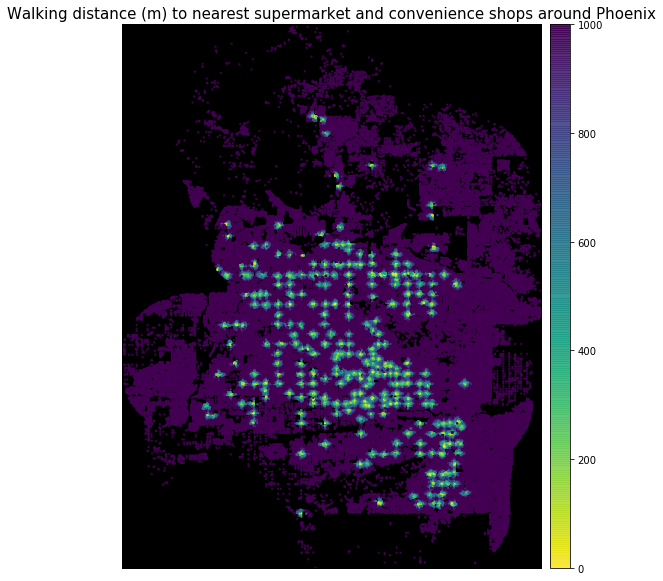

In [38]:
# distance to the nearest amenity of any type
n = 1
bmap, fig, ax = network.plot(all_access[n], plot_kwargs=plot_kwargs, fig_kwargs=fig_kwargs, bmap_kwargs=bmap_kwargs, cbar_kwargs=cbar_kwargs)
ax.set_facecolor(bgcolor)
ax.set_title('Walking distance ({}m) to nearest supermarket and convenience shops, {}'.format(distance, place), fontsize=15)
#fig.savefig('images/accessibility-shop-phx.png', dpi=200, bbox_inches='tight')

Note: need to discuss search distance and the number of pois; how to aggregate the result and determine the accessibility score